In [87]:
import polars as pl
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rcParams['text.usetex'] = True

In [125]:
def R2(y_pred: pl.Series, y_obs: pl.DataFrame):
    
    return 1 - ((y_pred - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def Q2(y_hat: pl.Series, y_obs: pl.DataFrame):

    return 1 - ((y_hat - y_obs.to_series())**2).sum() / ((y_obs.to_series() - y_obs.to_series().mean())**2).sum()

def RMSE(y_hat: pl.Series, y_obs: pl.DataFrame):

    return (((y_hat - y_obs.to_series())**2).sum()/y_obs.shape[0])**0.5

In [88]:
sheet_names = ('Yt', 'Yv', 'Xt', "Xv")

# Importowanie nieautoskalowanego zestawu danych

Yt i Yv - wartości modelowanej wielkości (energia adsorpcji aminokwasu na powierzchni nanocząstki złota) odpowiednio dla związków ze zbioru uczącego i walidacyjnego

Xt i Xv - deskryptory obliczone odpowiednio dla związku ze zmienną zależną

In [89]:
input_data = pl.read_excel(
    source="AA-AuNP.xlsx",
    sheet_name=sheet_names
)

In [90]:
input_data['Xt'].head()

Amino acid,HOMO[eV],LUMO [eV],Ionization potential [eV],Electron affinity [eV],Hardness,Softness,Electronegativity [Ev],Polarizability [au],Enthalpy [Hartree],Atom count,Heavy atom count,Asymmetric atom count,Rotatable bond count,Ring count,Aromatic ring count,Hetero ring count,FSP3,Hydrogen bond donor count,Hydrogen bond acceptor count,Formal charge,Topological polar surface area,Polarizability,Molar refractivity,HLB,logP,Van der Waals volume,Van der Waals surface area,Solvent accessible surface area,Topological polar surface area_1,Minimum projection area,Maximum projection area,Minimum projection radius,Maximum projection radius
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""A""",-5.952265,-1.22425,8.823835,-0.459455,4.641645,0.215441,4.18219,55.04,-323.370475,13,6,1,1,0,0,0,0.67,2,3,0,63.32,8.36,20.5,17.181,-2.841,84.93,142.15,235.74,63.32,22.27,29.61,3.02,3.84
"""C""",-5.795527,-1.3233,7.93835,0.030901,3.953725,0.252926,3.984626,74.97,-721.393083,14,7,1,2,0,0,0,0.67,3,3,0,63.32,11.42,28.22,19.67,-2.795,103.45,159.9,255.87,63.32,22.03,36.01,3.02,4.51
"""D""",-6.279077,-1.846307,8.812125,-0.04095,4.426538,0.22591,4.385588,74.0,-511.800495,16,9,1,3,0,0,0,0.5,3,5,0,100.62,10.9,26.53,18.948,-3.504,112.61,177.91,261.0,100.62,22.51,39.04,3.07,4.73
"""E""",-6.122066,-1.376907,8.569092,-0.169841,4.369466,0.228861,4.199626,85.88,-551.038643,19,10,1,4,0,0,0,0.6,3,5,0,100.62,12.69,31.29,17.981,-3.249,129.67,209.34,289.78,100.62,24.45,45.42,3.2,5.52
"""F""",-5.988185,-1.385615,7.80233,-0.233017,4.017674,0.2489,3.784656,123.73,-554.096836,23,12,1,3,1,1,0,0.22,2,3,0,63.32,17.89,45.12,13.109,-1.184,155.64,246.8,319.0,63.32,28.81,53.97,3.49,5.8


# Standaryzacja danych

In [91]:
std_data = {
    "Xt": input_data['Xt'].select(pl.exclude("Amino acid")).select((pl.all() - pl.all().mean())/pl.all().std()),
    "Xv": input_data['Xv'].select(pl.exclude("Amino acid")).select((pl.all() - pl.all().mean())/pl.all().std()),
    "Yt": input_data["Yt"].select(pl.exclude("Amino acid")),
    "Yv": input_data['Yv'].select(pl.exclude("Amino acid"))
}

In [92]:
std_data['Xt'].head()

HOMO[eV],LUMO [eV],Ionization potential [eV],Electron affinity [eV],Hardness,Softness,Electronegativity [Ev],Polarizability [au],Enthalpy [Hartree],Atom count,Heavy atom count,Asymmetric atom count,Rotatable bond count,Ring count,Aromatic ring count,Hetero ring count,FSP3,Hydrogen bond donor count,Hydrogen bond acceptor count,Formal charge,Topological polar surface area,Polarizability,Molar refractivity,HLB,logP,Van der Waals volume,Van der Waals surface area,Solvent accessible surface area,Topological polar surface area_1,Minimum projection area,Maximum projection area,Minimum projection radius,Maximum projection radius
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.512666,0.278151,1.069402,-0.964851,1.228204,-1.155538,0.809549,-1.293044,1.446939,-1.373412,-1.388808,-0.126892,-1.565007,-0.525173,-0.454447,-0.409447,0.330573,-0.955377,-0.809712,NaN,-0.8428,-1.30417,-1.249379,-0.20927,-0.109167,-1.469964,-1.433329,-1.258939,-0.8428,-0.846005,-1.45357,-0.727419,-1.427082
-0.104009,-0.187138,-0.39681,1.891728,-0.854217,0.809337,0.14344,-0.568139,-1.594197,-1.151894,-0.974239,-0.126892,-0.719057,-0.525173,-0.454447,-0.409447,0.330573,0.409447,-0.809712,NaN,-0.8428,-0.506417,-0.517406,0.610744,-0.062388,-0.818842,-1.038274,-0.746644,-0.8428,-0.915267,-0.799269,-0.727419,-0.625955
-1.364744,-2.643964,1.050014,1.473159,0.577048,-0.606764,1.495327,-0.603421,0.007218,-0.708858,-0.145099,-0.126892,0.126892,-0.525173,-0.454447,-0.409447,-0.455405,0.409447,1.503751,NaN,1.00711,-0.641983,-0.677644,0.372877,-0.783387,-0.496797,-0.637431,-0.616089,1.00711,-0.776744,-0.489499,-0.60135,-0.362899
-0.955378,-0.438956,0.647592,0.722304,0.404286,-0.452096,0.868336,-0.171315,-0.292585,-0.044304,0.26947,-0.126892,0.972842,-0.525173,-0.454447,-0.409447,0.006935,0.409447,1.503751,NaN,1.00711,-0.175323,-0.226324,0.054294,-0.524072,0.102995,0.062096,0.116341,1.00711,-0.216876,0.162757,-0.27357,0.581714
-0.606317,-0.479861,-0.622036,0.354265,-0.660635,0.598315,-0.530778,1.205387,-0.315952,0.841769,1.098609,-0.126892,0.126892,1.225403,1.36334,-0.409447,-1.749956,-0.955377,-0.809712,NaN,-0.8428,1.180336,1.08497,-1.550811,1.575876,1.016042,0.895831,0.85997,-0.8428,1.041382,1.036862,0.457631,0.916513


In [93]:
std_data['Xt'].select(pl.col("HOMO[eV]"), pl.col("Polarizability [au]"), pl.col("Topological polar surface area"))

HOMO[eV],Polarizability [au],Topological polar surface area
f64,f64,f64
-0.512666,-1.293044,-0.8428
-0.104009,-0.568139,-0.8428
-1.364744,-0.603421,1.00711
-0.955378,-0.171315,1.00711
-0.606317,1.205387,-0.8428
…,…,…
-0.861727,-1.123185,0.160516
-0.999365,-0.678348,0.160516
-0.461584,-0.409191,-0.8428


# Modelowanie PLS

In [94]:
hidden_variables = {
    "Xt": std_data['Xt'].select(pl.col("HOMO[eV]"), pl.col("Polarizability [au]"), pl.col("Topological polar surface area")),
    'Xv': std_data['Xv'].select(pl.col("HOMO[eV]"), pl.col("Polarizability [au]"), pl.col("Topological polar surface area"))
}

In [95]:
PLS_model = PLSRegression(
    n_components=1
).fit(
    hidden_variables['Xt'],
    std_data['Yt']
)

In [96]:
PLS_model

PLSRegression(n_components=1)

In [ ]:
PLS_predictions = {
    "Yt": PLS_model.predict(hidden_variables['Xt']),
    "Yv": PLS_model.predict(hidden_variables["Xv"])
}

# Wykres $y_{pred}$ od $y_{obs}$ z podziałem na zbiór uczący i walidacyjny

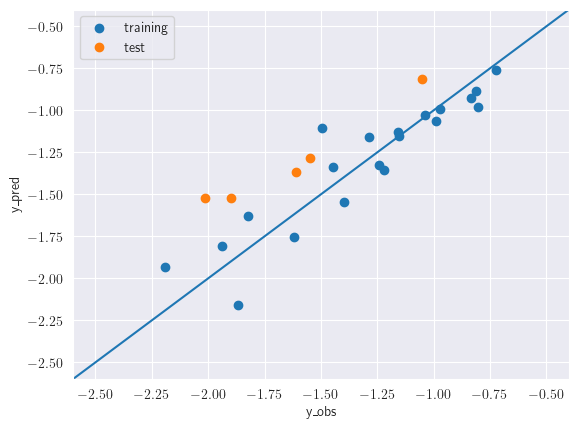

In [98]:
plt.scatter(std_data['Yt'], PLS_predictions['Yt'], label="training")
plt.scatter(std_data['Yv'], PLS_predictions['Yv'], label="test")
plt.legend()
plt.xlabel("y_{obs}")
plt.ylabel("y_{pred}")
plt.axline((-2.5,-2.5), (-0.5,-0.5))

# Obliczenie statystyk

In [106]:
#PLS_predictions['Yt'].shape
std_data['Yt']

AA-AuNP
f64
-0.813347
-1.493549
-0.973356
-1.28657
-1.4453
…
-0.835206
-0.804496
-0.98744


$R^2$

In [107]:
R2(
    PLS_predictions['Yt'].flatten(),
    std_data['Yt']
)

0.847115954331954

$RMSE_c$

In [108]:
RMSE(
    PLS_predictions['Yt'].flatten(),
    std_data['Xt']
)

1.8538246943036898

$Q^2_{cv}$

$RMSE_{cv}$

$Q^2_{ext}$

In [127]:
Q2(
    PLS_predictions['Yv'].flatten(),
    std_data['Yv']
)

-0.01509981808630978

$RMSE_{ext}$

# Model MLR

# Model PCR